# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.calibration import CalibrationDisplay

from mapie.metrics.calibration import expected_calibration_error

import pickle as pkl

import time

from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [15]:
train = pd.read_csv('DATA/train.csv', low_memory=False)
valid = pd.read_csv('DATA/valid.csv', low_memory=False)
test = pd.read_csv('DATA/test.csv', low_memory=False)

In [16]:
dev = pd.concat([train, valid], axis=0).reset_index(drop=True)

# Helper

In [6]:
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

In [17]:
def target_encoding(train_df, feature, target='target', min_samples_leaf=1000):
    """
    Encodes categories by merging each rare category into the existing group
    with the most similar target mean, ensuring monotonicity.
    """
    # 1. Calculate initial statistics for all categories
    stats = train_df.groupby(feature)[target].agg(['mean', 'count'])

    # 2. Separate frequent categories (our initial final groups) from rare ones
    frequent_stats = stats[stats['count'] >= min_samples_leaf].copy()
    rare_stats = stats[stats['count'] < min_samples_leaf].copy()

    # This dictionary will hold our final merged groups and their updated stats
    final_groups = frequent_stats.to_dict('index')
    # This dictionary maps each original category to its final merged group label
    # Initially, frequent categories map to themselves
    category_to_group_map = {cat: cat for cat in frequent_stats.index}

    # 3. Iteratively merge each rare category into the best-fitting final group
    # We process from largest rare group to smallest for stability
    for rare_cat, row in rare_stats.sort_values('count', ascending=False).iterrows():
        rare_mean = row['mean']
        rare_count = row['count']

        # Find the most similar group in our current set of final_groups
        # We calculate the absolute difference in means to find the closest one
        best_match_label = min(
            final_groups.keys(),
            key=lambda k: abs(final_groups[k]['mean'] - rare_mean)
        )

        # 4. Update the stats of the best-matching group with the rare category's data
        match_stats = final_groups[best_match_label]
        match_mean = match_stats['mean']
        match_count = match_stats['count']

        # Calculate the new weighted average mean and the new total count
        new_count = match_count + rare_count
        new_mean = ((match_mean * match_count) + (rare_mean * rare_count)) / new_count

        # Update the final group's stats
        final_groups[best_match_label]['mean'] = new_mean
        final_groups[best_match_label]['count'] = new_count

        # Update the mapping for the rare category
        category_to_group_map[rare_cat] = best_match_label

    # 5. Create the final ordinal encoding based on the sorted means of the final groups
    # Convert final_groups dict back to a DataFrame for easy sorting
    final_groups_df = pd.DataFrame.from_dict(final_groups, orient='index')
    sorted_group_labels = final_groups_df.sort_values('mean').index
    
    ordinal_map = {label: i for i, label in enumerate(sorted_group_labels)}

    # 6. Create the full, final map from original category to its final ordinal encoding
    full_final_map = {
        original_cat: ordinal_map[merged_label]
        for original_cat, merged_label in category_to_group_map.items()
    }

    # 7. Apply the mapping to the training data
    train_encoded = train_df.copy()
    train_encoded[f'{feature}_encoded'] = train_encoded[feature].map(full_final_map)
    
    # We need the full_final_map to transform the test set later
    # We also need a default value for categories that might be in test but not train
    # A good default is the median encoded value
    # default_value = np.median(list(ordinal_map.values()))

    return train_encoded, full_final_map #, default_value

# Actual Bootstrapping

In [19]:
num_bootstrap = 500

modeling_features = ['person_income', 'person_home_ownership_encoded', 'person_emp_length',
       'loan_intent_encoded', 'loan_grade_encoded', 'loan_amnt',
       'loan_percent_income', 'cb_person_default_on_file_encoded',
       'cb_person_cred_hist_length']

numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

missing_features = ['person_emp_length', 'loan_int_rate']

t0 = time.time()

for i in tqdm(range(1, num_bootstrap + 1)):

    # bootstrap sample
    boot_sample = resample(dev, replace=True, stratify=dev['loan_intent'], random_state=i)

    # train-validation split
    train_boot, valid_boot = train_test_split(boot_sample, test_size=0.2, stratify=boot_sample['loan_intent'], random_state=i)

    ############################  Outlier Capping ##########################################

    capping_values = {}

    for col in numerical_features:
        # Calculate the 1st and 99th percentiles using the training data
        lower_bound = train_boot[col].quantile(0.01)
        upper_bound = train_boot[col].quantile(0.99)
        
        # Store the bounds in the dictionary
        capping_values[col] = {'lower': lower_bound, 'upper': upper_bound}

        train_boot[col] = np.clip(train_boot[col], lower_bound, upper_bound)
        valid_boot[col] = np.clip(valid_boot[col], lower_bound, upper_bound)
    
    # save capping boundaries
    with open(f'Bootstrap/Outlier capping/bootstrap_{i}_capping_values.pkl', 'wb') as f:
        pkl.dump(capping_values, f)


    ############################## Missing value imputation ##############################

    # Calculate mean for each group only from training data

    group_means = {}

    for col in missing_features:
        # Calculate group means only on the training set
        group_means[col] = train_boot.dropna(subset=[col]).groupby('loan_grade')[col].mean().to_dict()

        # Map the training data
        train_boot[col] = train_boot[col].fillna(train_boot['loan_grade'].map(group_means[col]))

        # Map the validation data (using training group means only)
        valid_boot[col] = valid_boot[col].fillna(valid_boot['loan_grade'].map(group_means[col]))


    # save missing value imputation mappings
    with open(f'Bootstrap/Missing value imputation/bootstrap_{i}_group_means.pkl', 'wb') as f:
        pkl.dump(group_means, f)


    ############################# Categorical feature encoding #################################

    cat_maps = {}

    for col in categorical_features:

        # define target encoding on train set
        train_boot, cat_maps[col] = target_encoding(train_boot, col, target='loan_status', min_samples_leaf=1000)
    
        # apply on validation set
        valid_boot[f'{col}_encoded'] = valid_boot[col].map(cat_maps[col])

    # save categorical feature mappings
    with open(f'Bootstrap/Categorical feature encoding/bootstrap_{i}_cat_maps.pkl', 'wb') as f:
        pkl.dump(cat_maps, f)

    
    ############################ Data standardization ############################

    train_boot = train_boot[modeling_features + ['loan_status']]
    valid_boot = valid_boot[modeling_features + ['loan_status']]

    scaler = StandardScaler()
    train_boot[modeling_features] = scaler.fit_transform(train_boot[modeling_features])
    valid_boot[modeling_features] = scaler.transform(valid_boot[modeling_features])

    # save scaler
    with open(f'Bootstrap/Data standardization/bootstrap_{i}_scaler.pkl', 'wb') as f:
        pkl.dump(scaler, f)


    ############################# Logistic regression ############################

    model = LogisticRegression(random_state=42, penalty=None)
    model.fit(train_boot[modeling_features], train_boot['loan_status'])

    # save model
    with open(f'Bootstrap/Logistic regression/bootstrap_{i}_lr_model.pkl', 'wb') as f:
        pkl.dump(model, f)


    ########################## Isotonic regression (calibration) ##########################

    iso_model = IsotonicRegression(out_of_bounds='clip')
    iso_model.fit(model.predict_proba(train_boot[modeling_features])[:, 1], train_boot['loan_status'])

    # save model
    with open(f'Bootstrap/Calibration/bootstrap_{i}_iso_model.pkl', 'wb') as f:
        pkl.dump(iso_model, f)

t1 = time.time()
print(f"Bootstrap iterations completed in {t1 - t0:.2f} seconds.")

100%|██████████| 500/500 [01:49<00:00,  4.57it/s]

Bootstrap iterations completed in 109.39 seconds.


# Bootstrap model predictions on test set

In [20]:
num_bootstrap = 500
test_predictions = {}

for i in tqdm(range(1, num_bootstrap + 1)):

    ################################ Test set data transformation ####################################

    test_boot = test.copy()

    ################################# Outlier Capping #################################

    with open(f'Bootstrap/Outlier capping/bootstrap_{i}_capping_values.pkl', 'rb') as f:
        capping_values = pkl.load(f)

    for col in numerical_features:
        test_boot[col] = np.clip(test_boot[col], capping_values[col]['lower'], capping_values[col]['upper'])


    ################################ Missing value imputation #############################

    with open(f'Bootstrap/Missing value imputation/bootstrap_{i}_group_means.pkl', 'rb') as f:
        group_means = pkl.load(f)

    for col in missing_features:
        test_boot[col] = test_boot[col].fillna(test_boot['loan_grade'].map(group_means[col]))

    ############################# Categorical feature encoding #################################

    with open(f'Bootstrap/Categorical feature encoding/bootstrap_{i}_cat_maps.pkl', 'rb') as f:
        cat_maps = pkl.load(f)

    for col in categorical_features:
        test_boot[f'{col}_encoded'] = test_boot[col].map(cat_maps[col])

    ############################ Data standardization ############################

    with open(f'Bootstrap/Data standardization/bootstrap_{i}_scaler.pkl', 'rb') as f:
        scaler = pkl.load(f)

    test_boot[modeling_features] = scaler.transform(test_boot[modeling_features])


    ############################# Logistic regression predictions ############################

    with open(f'Bootstrap/Logistic regression/bootstrap_{i}_lr_model.pkl', 'rb') as f:
        model = pkl.load(f)

    test_boot['predicted_prob'] = model.predict_proba(test_boot[modeling_features])[:, 1]

    ########################## Isotonic regression (calibration) predictions ##########################

    with open(f'Bootstrap/Calibration/bootstrap_{i}_iso_model.pkl', 'rb') as f:
        iso_model = pkl.load(f)

    test_boot['calibrated_prob'] = iso_model.predict(test_boot['predicted_prob'].values.reshape(-1, 1))

    test_boot['bootstrap_iteration'] = i

    # save test predictions
    test_predictions[i] = test_boot[['ID', 'predicted_prob', 'calibrated_prob', 'bootstrap_iteration', 'loan_status']]

100%|██████████| 500/500 [01:03<00:00,  7.87it/s]


In [21]:
# save test set predictions
with open('Bootstrap/Test predictions/test_set_bootstrap_predictions_v2.pkl', 'wb') as f:
    pkl.dump(test_predictions, f)

# Analysis

In [4]:
with open('Bootstrap/Test predictions/test_set_bootstrap_predictions_v2.pkl', 'rb') as f:
    # Use pkl.load() to load the object from the file
    test_predictions = pkl.load(f)

In [ ]:
sample  = test_predictions[500]

In [41]:
sample

,ID,predicted_prob,calibrated_prob,bootstrap_iteration,loan_status
0,20441,0.019891,0.034301,500,0
1,1091,0.876738,0.903509,500,1
2,4763,0.273011,0.251098,500,0
3,12382,0.616346,0.641350,500,0
4,15113,0.011089,0.021667,500,0
...,...,...,...,...,...
6479,30557,0.045811,0.056321,500,1
6480,27990,0.288311,0.251098,500,0
6481,5816,0.130823,0.097608,500,0
6482,24321,0.322194,0.270270,500,0


In [43]:
print('Log loss for raw scores:')
print(round(log_loss(sample['loan_status'], sample['predicted_prob']), 3))

print('Log loss for calibrated scores:')
print(round(log_loss(sample['loan_status'], sample['calibrated_prob']), 3))

Log loss for raw scores:
0.357
Log loss for calibrated scores:
0.374


In [44]:
print('Brier score for raw scores:')
print(round(brier_score_loss(sample['loan_status'], sample['predicted_prob']), 3))

print('Brier score for calibrated scores:')
print(round(brier_score_loss(sample['loan_status'], sample['calibrated_prob']), 3))

Brier score for raw scores:
0.109
Brier score for calibrated scores:
0.109


In [45]:
print("ROC AUC score for raw scores:")
print(round(roc_auc_score(sample['loan_status'], sample['predicted_prob']), 3))

print("ROC AUC score for calibrated scores:")
print(round(roc_auc_score(sample['loan_status'], sample['calibrated_prob']), 3))

ROC AUC score for raw scores:
0.858
ROC AUC score for calibrated scores:
0.857


In [46]:
# calibration curve
pred_list = [
    ("predicted_prob", "Logistic"),
    ("calibrated_prob", "Logistic + Isotonic"),
]

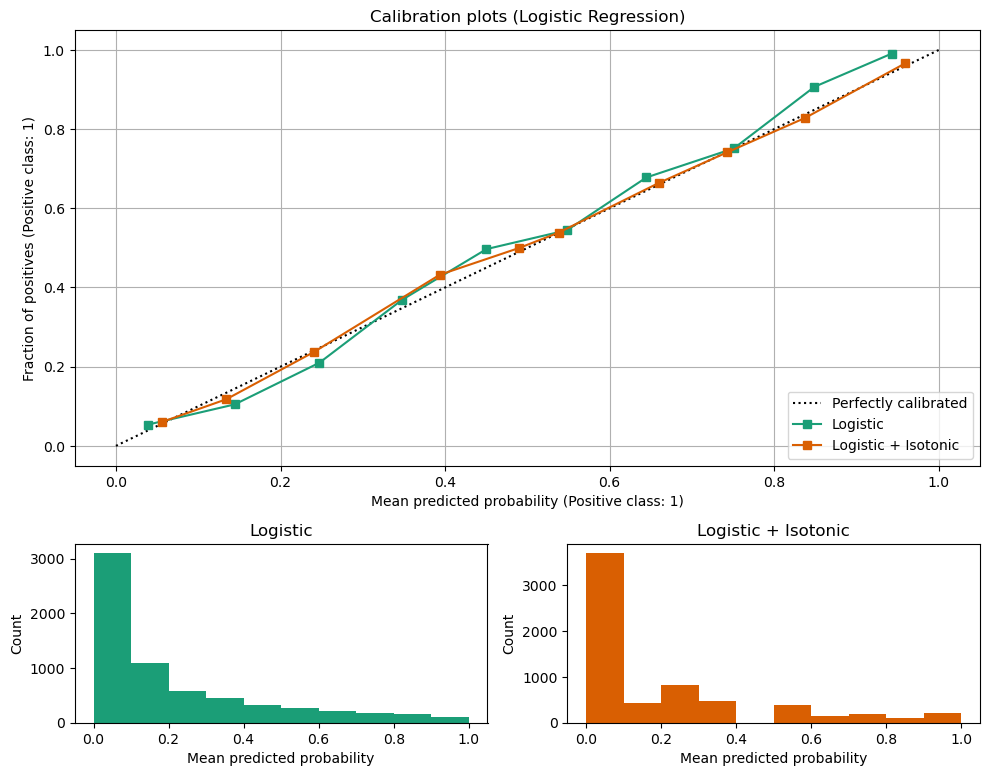

In [47]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (pred, name) in enumerate(pred_list):

    display = CalibrationDisplay.from_predictions(
        sample['loan_status'],
        sample[pred],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        # strategy="quantile"
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Logistic Regression)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [49]:
sample[['predicted_prob', 'calibrated_prob']].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

,predicted_prob,calibrated_prob
0.0,0.001169,0.000000
0.1,0.014814,0.024341
0.2,0.025711,0.055340
0.3,0.044366,0.056321
0.4,0.069771,0.078324
0.5,0.110027,0.095012
0.6,0.166136,0.141626
0.7,0.251849,0.251098
0.8,0.391950,0.397101
0.9,0.605286,0.641350


In [5]:
rows = []

num_bootstrap = 500

for i in tqdm(range(1, num_bootstrap + 1)):
    sample = test_predictions[i]

    rows.append({
        'Bootstrap Iteration': i,
        'Brier Score (Raw)': round(brier_score_loss(sample['loan_status'], sample['predicted_prob']),3),
        'Brier Score (Calibrated)': round(brier_score_loss(sample['loan_status'], sample['calibrated_prob']),3),
        'Log Loss (Raw)': round(log_loss(sample['loan_status'], sample['predicted_prob']),3),
        'Log Loss (Calibrated)': round(log_loss(sample['loan_status'], sample['calibrated_prob']),3),
        'ECE (Raw)': round(expected_calibration_error(sample['loan_status'], sample['predicted_prob'], num_bins=10, split_strategy='uniform'),3),
        'ECE (Calibrated)': round(expected_calibration_error(sample['loan_status'], sample['calibrated_prob'], num_bins=10, split_strategy='uniform'),3),
        'ROC AUC (Raw)': round(roc_auc_score(sample['loan_status'], sample['predicted_prob']),3),
        'ROC AUC (Calibrated)': round(roc_auc_score(sample['loan_status'], sample['calibrated_prob']),3),
    })

metrics = pd.DataFrame(rows)

100%|██████████| 500/500 [00:12<00:00, 39.99it/s]


In [6]:
metrics

,Bootstrap Iteration,Brier Score (Raw),Brier Score (Calibrated),Log Loss (Raw),Log Loss (Calibrated),ECE (Raw),ECE (Calibrated),ROC AUC (Raw),ROC AUC (Calibrated)
0,1,0.109,0.109,0.357,0.380,0.019,0.016,0.859,0.857
1,2,0.109,0.109,0.357,0.360,0.020,0.008,0.859,0.858
2,3,0.109,0.108,0.357,0.360,0.021,0.011,0.858,0.858
3,4,0.109,0.109,0.357,0.378,0.021,0.011,0.859,0.858
4,5,0.109,0.109,0.357,0.379,0.022,0.016,0.858,0.858
...,...,...,...,...,...,...,...,...,...
495,496,0.109,0.109,0.357,0.360,0.022,0.012,0.858,0.857
496,497,0.109,0.108,0.357,0.358,0.022,0.009,0.858,0.858
497,498,0.109,0.109,0.357,0.360,0.022,0.012,0.858,0.857
498,499,0.109,0.108,0.357,0.369,0.020,0.009,0.858,0.858


In [7]:
metrics[metrics['Log Loss (Raw)'] > metrics['Log Loss (Calibrated)']]

,Bootstrap Iteration,Brier Score (Raw),Brier Score (Calibrated),Log Loss (Raw),Log Loss (Calibrated),ECE (Raw),ECE (Calibrated),ROC AUC (Raw),ROC AUC (Calibrated)


In [8]:
metrics[metrics['Brier Score (Raw)'] <= metrics['Brier Score (Calibrated)']]

,Bootstrap Iteration,Brier Score (Raw),Brier Score (Calibrated),Log Loss (Raw),Log Loss (Calibrated),ECE (Raw),ECE (Calibrated),ROC AUC (Raw),ROC AUC (Calibrated)
0,1,0.109,0.109,0.357,0.380,0.019,0.016,0.859,0.857
1,2,0.109,0.109,0.357,0.360,0.020,0.008,0.859,0.858
3,4,0.109,0.109,0.357,0.378,0.021,0.011,0.859,0.858
4,5,0.109,0.109,0.357,0.379,0.022,0.016,0.858,0.858
5,6,0.109,0.109,0.357,0.360,0.021,0.013,0.858,0.858
...,...,...,...,...,...,...,...,...,...
492,493,0.109,0.109,0.357,0.365,0.023,0.010,0.859,0.858
494,495,0.109,0.109,0.357,0.379,0.023,0.013,0.858,0.857
495,496,0.109,0.109,0.357,0.360,0.022,0.012,0.858,0.857
497,498,0.109,0.109,0.357,0.360,0.022,0.012,0.858,0.857


In [9]:
metrics[metrics['ECE (Raw)'] >= metrics['ECE (Calibrated)']]

,Bootstrap Iteration,Brier Score (Raw),Brier Score (Calibrated),Log Loss (Raw),Log Loss (Calibrated),ECE (Raw),ECE (Calibrated),ROC AUC (Raw),ROC AUC (Calibrated)
0,1,0.109,0.109,0.357,0.380,0.019,0.016,0.859,0.857
1,2,0.109,0.109,0.357,0.360,0.020,0.008,0.859,0.858
2,3,0.109,0.108,0.357,0.360,0.021,0.011,0.858,0.858
3,4,0.109,0.109,0.357,0.378,0.021,0.011,0.859,0.858
4,5,0.109,0.109,0.357,0.379,0.022,0.016,0.858,0.858
...,...,...,...,...,...,...,...,...,...
495,496,0.109,0.109,0.357,0.360,0.022,0.012,0.858,0.857
496,497,0.109,0.108,0.357,0.358,0.022,0.009,0.858,0.858
497,498,0.109,0.109,0.357,0.360,0.022,0.012,0.858,0.857
498,499,0.109,0.108,0.357,0.369,0.020,0.009,0.858,0.858


In [10]:
metrics[metrics['ROC AUC (Raw)'] <= metrics['ROC AUC (Calibrated)']]

,Bootstrap Iteration,Brier Score (Raw),Brier Score (Calibrated),Log Loss (Raw),Log Loss (Calibrated),ECE (Raw),ECE (Calibrated),ROC AUC (Raw),ROC AUC (Calibrated)
2,3,0.109,0.108,0.357,0.360,0.021,0.011,0.858,0.858
4,5,0.109,0.109,0.357,0.379,0.022,0.016,0.858,0.858
5,6,0.109,0.109,0.357,0.360,0.021,0.013,0.858,0.858
6,7,0.109,0.109,0.358,0.366,0.023,0.011,0.858,0.858
7,8,0.109,0.109,0.358,0.360,0.021,0.015,0.858,0.858
...,...,...,...,...,...,...,...,...,...
485,486,0.109,0.109,0.356,0.361,0.019,0.012,0.859,0.859
486,487,0.109,0.109,0.357,0.379,0.023,0.008,0.858,0.858
489,490,0.109,0.109,0.356,0.384,0.021,0.016,0.859,0.859
496,497,0.109,0.108,0.357,0.358,0.022,0.009,0.858,0.858


# Prediction Intervals

In [12]:
boot_pred = pd.concat(test_predictions.values(), ignore_index=True)

In [15]:
boot_pred['calibrated_class'] = (boot_pred['calibrated_prob'] >= 0.3).astype(int)

In [16]:
print(precision_score(boot_pred['loan_status'], boot_pred['calibrated_class']))
print(recall_score(boot_pred['loan_status'], boot_pred['calibrated_class']))

0.6116066089372822
0.681363571934798


In [17]:
# calculate prediction interval

prediction_intervals = boot_pred.groupby('ID')['calibrated_prob'].agg(
    lower_bound=lambda x: np.percentile(x, 2.5),
    upper_bound=lambda x: np.percentile(x, 97.5),
    mean_prob=lambda x: np.mean(x),  # It's also useful to get the mean prediction
).reset_index()

In [18]:
# calculate interval length

prediction_intervals['interval_length'] = prediction_intervals['upper_bound'] - prediction_intervals['lower_bound']

In [19]:
prediction_intervals = prediction_intervals.merge(boot_pred[['ID', 'loan_status']].drop_duplicates(), on='ID', how='inner')

In [20]:
prediction_intervals.sort_values('mean_prob', inplace=True, ignore_index=True)

## Calibration curve of Prediction Intervals

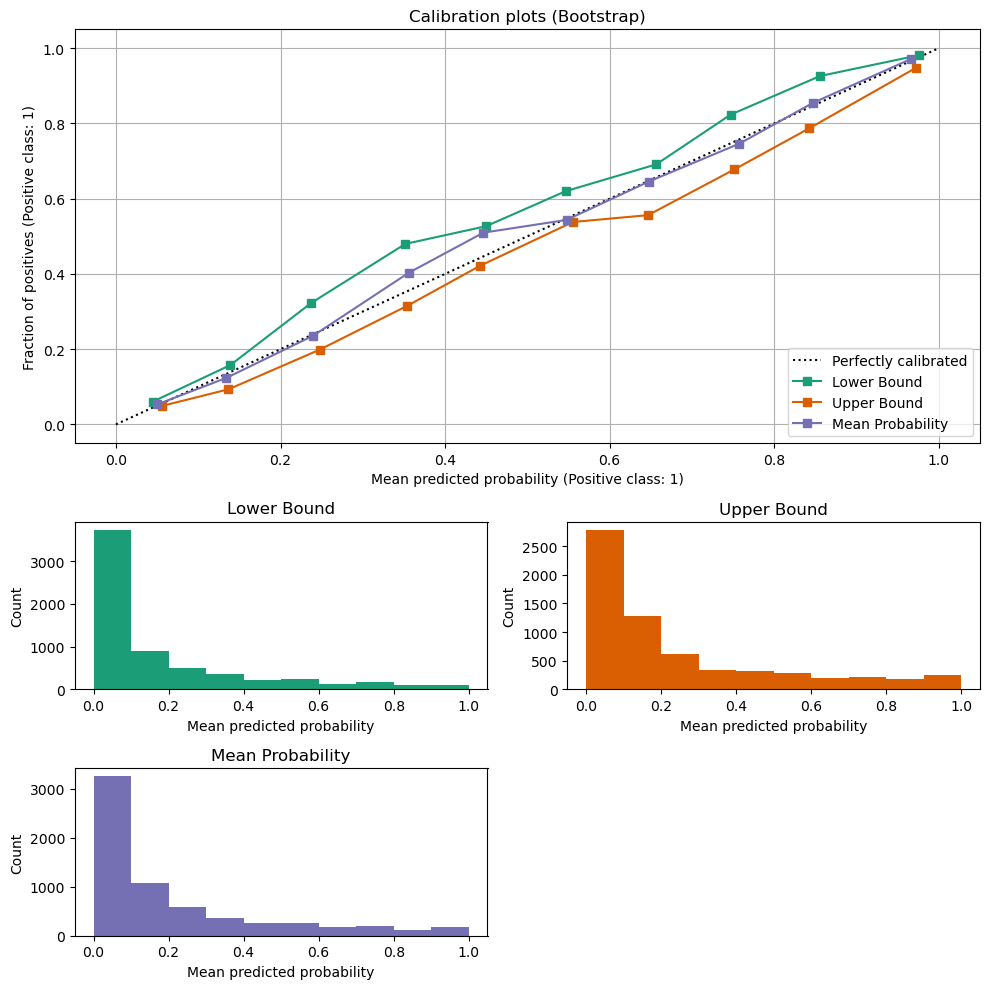

In [ ]:
# calibration curve
pred_list = [
    ("lower_bound", "Lower Bound"),
    ("upper_bound", "Upper Bound"),
    ("mean_prob", "Mean Probability"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (pred, name) in enumerate(pred_list):

    display = CalibrationDisplay.from_predictions(
        prediction_intervals['loan_status'],
        prediction_intervals[pred],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        # strategy="quantile"
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Bootstrap)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [22]:
print('ECE lower bound:', round(expected_calibration_error(prediction_intervals['loan_status'], prediction_intervals['lower_bound'], num_bins=10, split_strategy='uniform'),3))
print('ECE upper bound:', round(expected_calibration_error(prediction_intervals['loan_status'], prediction_intervals['upper_bound'], num_bins=10, split_strategy='uniform'),3))
print('ECE mean prob:', round(expected_calibration_error(prediction_intervals['loan_status'], prediction_intervals['mean_prob'], num_bins=10, split_strategy='uniform'),3))

ECE lower bound: 0.035
ECE upper bound: 0.028
ECE mean prob: 0.011


## CDF of Prediction Intervals


--- Visualizing CDF of Prediction Intervals ---


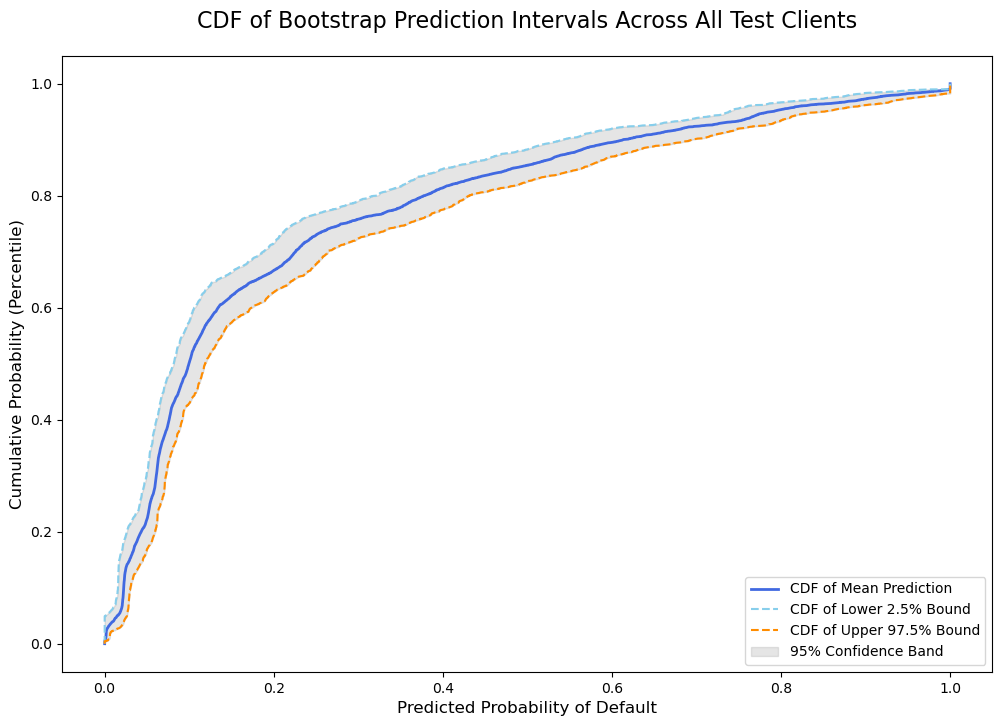

In [ ]:
# Visualize CDF of Prediction Intervals Across All Clients ---
print("\n--- Visualizing CDF of Prediction Intervals ---")

# We will plot the CDF for the mean predictions, and the lower/upper bounds
mean_probs_sorted = np.sort(prediction_intervals['mean_prob'])
lower_bounds_sorted = np.sort(prediction_intervals['lower_bound'])
upper_bounds_sorted = np.sort(prediction_intervals['upper_bound'])

# The y-axis for a CDF is the percentile, from 0 to 1
y_axis = np.linspace(0, 1, len(prediction_intervals))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three CDFs
ax.plot(mean_probs_sorted, y_axis, label='CDF of Mean Prediction', color='royalblue', linewidth=2)
ax.plot(lower_bounds_sorted, y_axis, label='CDF of Lower 2.5% Bound', color='skyblue', linestyle='--')
ax.plot(upper_bounds_sorted, y_axis, label='CDF of Upper 97.5% Bound', color='darkorange', linestyle='--')

# Add shading to represent the 95% confidence interval band
ax.fill_betweenx(y_axis, lower_bounds_sorted, upper_bounds_sorted, color='gray', alpha=0.2, label='95% Confidence Band')

ax.set_title('CDF of Bootstrap Prediction Intervals Across All Test Clients', fontsize=16, pad=20)
ax.set_xlabel('Predicted Probability of Default', fontsize=12)
ax.set_ylabel('Cumulative Probability (Percentile)', fontsize=12)
ax.legend(loc='lower right')
plt.show()


In [27]:
prediction_intervals['interval_length'].mean()

0.06271440885460618

In [31]:
prediction_intervals['mean_prob_bin'] = pd.cut(prediction_intervals['mean_prob'], bins=np.linspace(0, 1, 11), include_lowest=True)

# 3. Calculate the mean width and mean predicted probability for each bin
sharpness_df = prediction_intervals.groupby('mean_prob_bin').agg(
    mean_width=('interval_length', 'mean'),
    mean_mean_prob=('mean_prob', 'mean'), # The center of the bin for plotting
    count=('interval_length', 'size')
).reset_index()

In [32]:
sharpness_df

,mean_prob_bin,mean_width,mean_mean_prob,count
0,"(-0.001, 0.1]",0.026034,0.050509,3254
1,"(0.1, 0.2]",0.062368,0.134167,1068
2,"(0.2, 0.3]",0.097893,0.239605,594
3,"(0.3, 0.4]",0.125889,0.356063,362
4,"(0.4, 0.5]",0.145859,0.446493,261
5,"(0.5, 0.6]",0.141465,0.547562,265
6,"(0.6, 0.7]",0.155954,0.647280,186
7,"(0.7, 0.8]",0.114212,0.757510,193
8,"(0.8, 0.9]",0.123418,0.847255,124
9,"(0.9, 1.0]",0.054715,0.966714,177


## Sharpness of Prediction Intervals

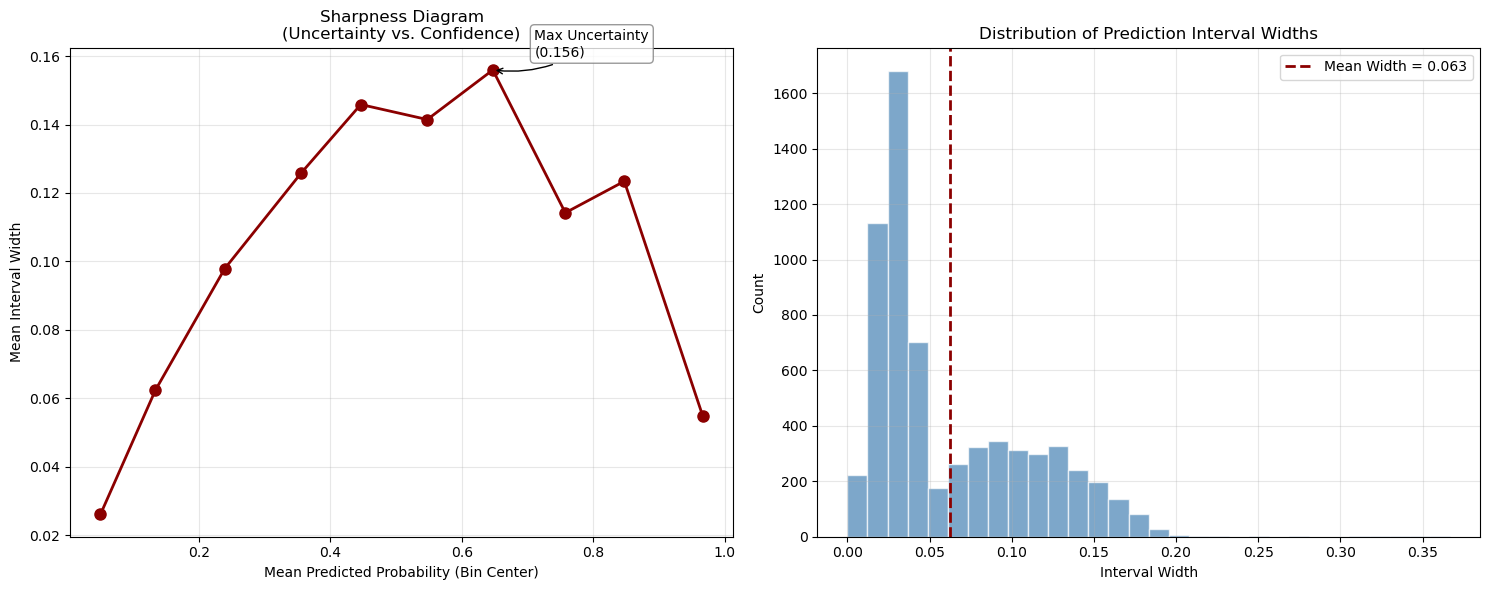

In [49]:
# 4. Create the Sharpness Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Plot 1: Mean Interval Width vs. Mean Prediction ---
ax1.plot(sharpness_df['mean_mean_prob'], sharpness_df['mean_width'], 'o-', color='darkred', linewidth=2, markersize=8)
ax1.set_xlabel('Mean Predicted Probability (Bin Center)')
ax1.set_ylabel('Mean Interval Width')
ax1.set_title('Sharpness Diagram\n(Uncertainty vs. Confidence)')
ax1.grid(True, alpha=0.3)

# Annotate the point with the maximum uncertainty (should be near 0.5)
max_width_idx = sharpness_df['mean_width'].idxmax()
ax1.annotate(f'Max Uncertainty\n({sharpness_df.loc[max_width_idx, "mean_width"]:.3f})', 
            xy=(sharpness_df.loc[max_width_idx, 'mean_mean_prob'], sharpness_df.loc[max_width_idx, 'mean_width']),
            xytext=(30, 10), textcoords='offset points',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

# --- Plot 2: Distribution of Interval Widths ---
# This is a histogram of all individual interval widths
ax2.hist(prediction_intervals['interval_length'], bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax2.set_xlabel('Interval Width')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Prediction Interval Widths')
ax2.grid(True, alpha=0.3)

# Add vertical line for the mean width
mean_width = prediction_intervals['interval_length'].mean()
ax2.axvline(mean_width, color='darkred', linestyle='--', linewidth=2, label=f'Mean Width = {mean_width:.3f}')
ax2.legend()

plt.tight_layout()
plt.show()


In [43]:
# 5. Print some key statistics
print("--- Interval Sharpness Diagnostics ---")
print(f"Average Interval Width: {prediction_intervals['interval_length'].mean():.4f}")
print(f"Minimum Interval Width: {prediction_intervals['interval_length'].min():.4f}")
print(f"Maximum Interval Width: {prediction_intervals['interval_length'].max():.4f}")
print(f"Standard Deviation of Width: {prediction_intervals['interval_length'].std():.4f}")
print(f"Median Interval Width: {prediction_intervals['interval_length'].median():.4f}")
print(f"Number of 'Certain' Predictions (width < 0.1): {(prediction_intervals['interval_length'] < 0.1).sum()}") 
print(f"Number of 'Highly Uncertain' Predictions (width > 0.5): {(prediction_intervals['interval_length'] > 0.5).sum()}")

--- Interval Sharpness Diagnostics ---
Average Interval Width: 0.0627
Minimum Interval Width: 0.0000
Maximum Interval Width: 0.3666
Standard Deviation of Width: 0.0482
Median Interval Width: 0.0395
Number of 'Certain' Predictions (width < 0.1): 4899
Number of 'Highly Uncertain' Predictions (width > 0.5): 0


In [47]:
prediction_intervals[prediction_intervals['interval_length'] == 0]

,ID,lower_bound,upper_bound,mean_prob,interval_length,loan_status,mean_prob_bin
0,23160,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]"
1,28977,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]"
2,23042,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]"
3,9385,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]"
4,30708,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]"
...,...,...,...,...,...,...,...
6479,24924,1.0,1.0,1.0,0.0,1,"(0.9, 1.0]"
6480,30405,1.0,1.0,1.0,0.0,1,"(0.9, 1.0]"
6481,17555,1.0,1.0,1.0,0.0,1,"(0.9, 1.0]"
6482,9708,1.0,1.0,1.0,0.0,1,"(0.9, 1.0]"


## Correlation of Prediction Intervals

--- Correlation Analysis: Error vs. Uncertainty ---
Spearman Correlation (Squared Error vs. Width): 0.8278 (p-value: 0.0000e+00)
Spearman Correlation (Absolute Error vs. Width): 0.8278 (p-value: 0.0000e+00)


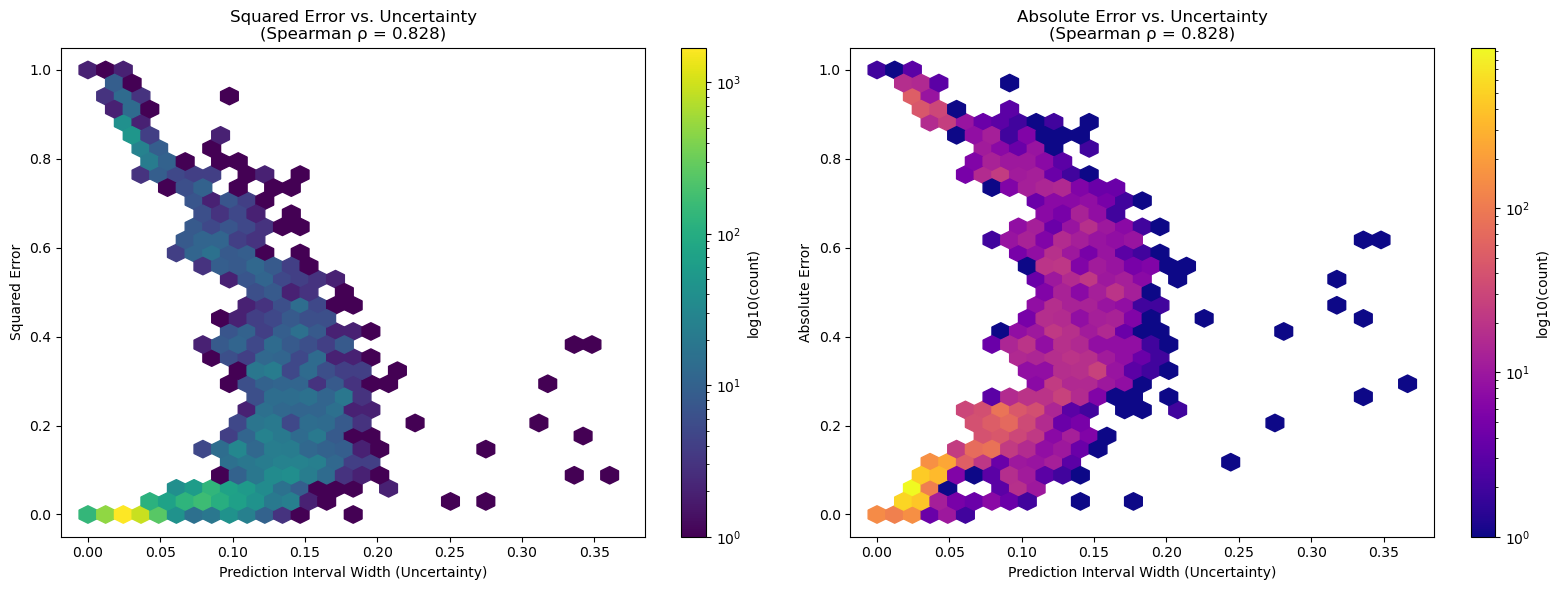

C:\Users\User\AppData\Local\Temp\ipykernel_20032\2850523442.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(data_to_plot, patch_artist=True, labels=bin_labels)


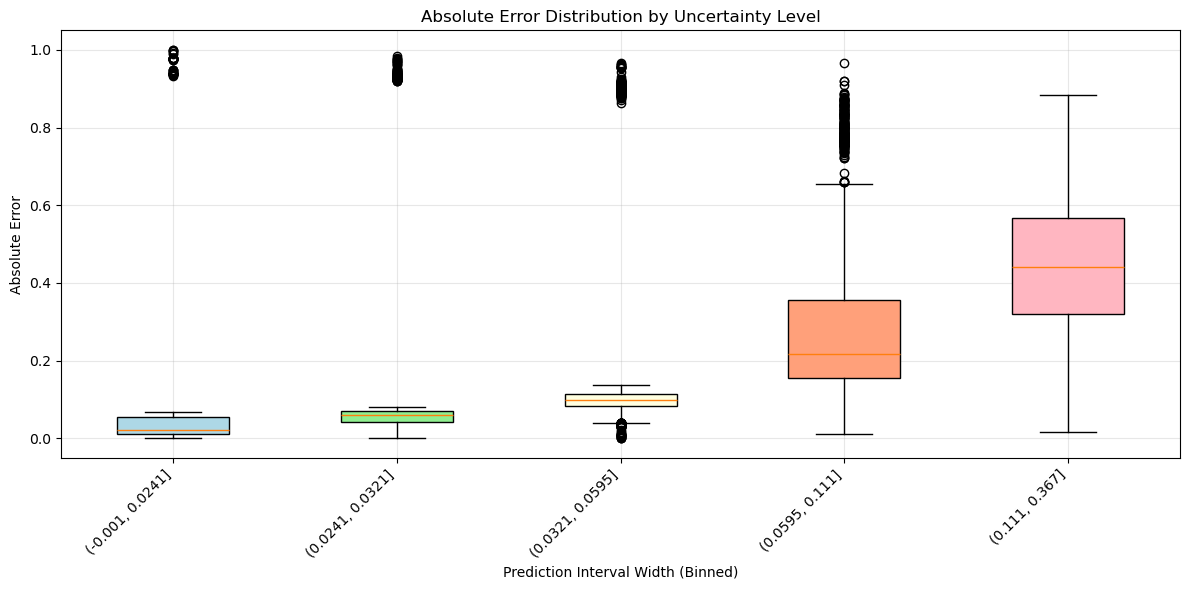


--- Error Statistics by Uncertainty Level ---
                      mean       std  count
width_bin                                  
(-0.001, 0.0241]  0.056511  0.163314   1297
(0.0241, 0.0321]  0.109409  0.213164   1297
(0.0321, 0.0595]  0.157699  0.225027   1296
(0.0595, 0.111]   0.307590  0.237545   1297
(0.111, 0.367]    0.446654  0.166976   1297


In [61]:
from scipy.stats import spearmanr

# Assuming your DataFrame is called 'prediction_intervals'
# and has columns: 'loan_status' (y_true), 'mean_prob', 'lower_bound', 'upper_bound'

# 1. Calculate the error for each instance.
prediction_intervals['se'] = (prediction_intervals['loan_status'] - prediction_intervals['mean_prob'])**2
prediction_intervals['ae'] = np.abs(prediction_intervals['loan_status'] - prediction_intervals['mean_prob'])

# 2. Calculate the interval width for each instance.
prediction_intervals['interval_length'] = prediction_intervals['upper_bound'] - prediction_intervals['lower_bound']

# 3. Calculate the Spearman's rank correlation between error and width.
corr_spearman_se, p_value_se = spearmanr(prediction_intervals['se'], prediction_intervals['interval_length'])
corr_spearman_ae, p_value_ae = spearmanr(prediction_intervals['ae'], prediction_intervals['interval_length'])

print("--- Correlation Analysis: Error vs. Uncertainty ---")
print(f"Spearman Correlation (Squared Error vs. Width): {corr_spearman_se:.4f} (p-value: {p_value_se:.4e})")
print(f"Spearman Correlation (Absolute Error vs. Width): {corr_spearman_ae:.4f} (p-value: {p_value_ae:.4e})")

# 4. Create a scatter plot to visualize the relationship.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Squared Error vs. Interval Width
hb1 = ax1.hexbin(prediction_intervals['interval_length'], prediction_intervals['se'], gridsize=30, cmap='viridis', bins='log')
ax1.set_xlabel('Prediction Interval Width (Uncertainty)')
ax1.set_ylabel('Squared Error')
ax1.set_title(f'Squared Error vs. Uncertainty\n(Spearman ρ = {corr_spearman_se:.3f})')
cb1 = fig.colorbar(hb1, ax=ax1)
cb1.set_label('log10(count)')

# Plot 2: Absolute Error vs. Interval Width
hb2 = ax2.hexbin(prediction_intervals['interval_length'], prediction_intervals['ae'], gridsize=30, cmap='plasma', bins='log')
ax2.set_xlabel('Prediction Interval Width (Uncertainty)')
ax2.set_ylabel('Absolute Error')
ax2.set_title(f'Absolute Error vs. Uncertainty\n(Spearman ρ = {corr_spearman_ae:.3f})')
cb2 = fig.colorbar(hb2, ax=ax2)
cb2.set_label('log10(count)')

plt.tight_layout()
plt.show()

# 5. FIXED BOXPLOT SECTION: Using matplotlib directly
# Create bins for the width and prepare data for boxplot
# We'll create 5 bins based on quantiles to have roughly equal number of points in each bin
try:
    prediction_intervals['width_bin'] = pd.qcut(prediction_intervals['interval_length'], q=5, duplicates='drop')
except ValueError as e:
    # If quantile binning fails (e.g., too many duplicate edges), use equal-width binning
    print("Quantile binning failed, using equal-width binning instead.")
    prediction_intervals['width_bin'] = pd.cut(prediction_intervals['interval_length'], bins=5)

# Get unique bins and sort them logically
unique_bins = sorted(prediction_intervals['width_bin'].unique())
bin_labels = [str(bin) for bin in unique_bins]

# Prepare data for boxplot: create a list of absolute error values for each bin
data_to_plot = []
for bin in unique_bins:
    bin_data = prediction_intervals[prediction_intervals['width_bin'] == bin]['ae']
    data_to_plot.append(bin_data)

# Create the boxplot using matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
boxplot = ax.boxplot(data_to_plot, patch_artist=True, labels=bin_labels)

# Add colors to the boxes
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightsalmon', 'lightpink']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xlabel('Prediction Interval Width (Binned)')
ax.set_ylabel('Absolute Error')
ax.set_title('Absolute Error Distribution by Uncertainty Level')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Additional analysis: Check error statistics by width bin
print("\n--- Error Statistics by Uncertainty Level ---")
width_bin_stats = prediction_intervals.groupby('width_bin')['ae'].agg(['mean', 'std', 'count'])
print(width_bin_stats)

In [54]:
corr_spearman_se

0.8278224311155515

In [62]:
corr_spearman_ae

0.8278224311155515

In [64]:
prediction_intervals

,ID,lower_bound,upper_bound,mean_prob,interval_length,loan_status,mean_prob_bin,se,ae,prediction_interval_bin,width_bin
0,23160,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]",0.0,0.0,"(-0.001, 0.0241]","(-0.001, 0.0241]"
1,28977,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]",0.0,0.0,"(-0.001, 0.0241]","(-0.001, 0.0241]"
2,23042,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]",0.0,0.0,"(-0.001, 0.0241]","(-0.001, 0.0241]"
3,9385,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]",0.0,0.0,"(-0.001, 0.0241]","(-0.001, 0.0241]"
4,30708,0.0,0.0,0.0,0.0,0,"(-0.001, 0.1]",0.0,0.0,"(-0.001, 0.0241]","(-0.001, 0.0241]"
...,...,...,...,...,...,...,...,...,...,...,...
6479,24924,1.0,1.0,1.0,0.0,1,"(0.9, 1.0]",0.0,0.0,"(-0.001, 0.0241]","(-0.001, 0.0241]"
6480,30405,1.0,1.0,1.0,0.0,1,"(0.9, 1.0]",0.0,0.0,"(-0.001, 0.0241]","(-0.001, 0.0241]"
6481,17555,1.0,1.0,1.0,0.0,1,"(0.9, 1.0]",0.0,0.0,"(-0.001, 0.0241]","(-0.001, 0.0241]"
6482,9708,1.0,1.0,1.0,0.0,1,"(0.9, 1.0]",0.0,0.0,"(-0.001, 0.0241]","(-0.001, 0.0241]"


In [65]:
prediction_intervals[100:105]

,ID,lower_bound,upper_bound,mean_prob,interval_length,loan_status,mean_prob_bin,se,ae,prediction_interval_bin,width_bin
100,23694,0.0,0.006195,0.001657,0.006195,0,"(-0.001, 0.1]",0.000003,0.001657,"(-0.001, 0.0241]","(-0.001, 0.0241]"
101,25681,0.0,0.006195,0.001657,0.006195,0,"(-0.001, 0.1]",0.000003,0.001657,"(-0.001, 0.0241]","(-0.001, 0.0241]"
102,11598,0.0,0.006195,0.001657,0.006195,0,"(-0.001, 0.1]",0.000003,0.001657,"(-0.001, 0.0241]","(-0.001, 0.0241]"
103,27315,0.0,0.006264,0.001658,0.006264,0,"(-0.001, 0.1]",0.000003,0.001658,"(-0.001, 0.0241]","(-0.001, 0.0241]"
104,25102,0.0,0.006283,0.001664,0.006283,0,"(-0.001, 0.1]",0.000003,0.001664,"(-0.001, 0.0241]","(-0.001, 0.0241]"
